In [1]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Train test split
from sklearn.model_selection import train_test_split

# Accuracy score.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, Bidirectional, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D


# Session Clearing.
from keras.backend import clear_session
clear_session()


#Resampling
from sklearn.utils import resample

# # Importing CSV from Kaggle
# import kagglehub

# Data Splitting and Pre-processing

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CSE427/Project/train.csv')
df = df[['text', 'target',]]
df.rename(columns={'target':'label'}, inplace=True )
df.rename(columns={'text':'text'}, inplace=True )
df.head(10)

,text,label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


In [3]:
tweet = df['text'].values
y = df['label'].values
df.describe()

,label
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [4]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4342   4315  The Prophet (peace be upon him) said 'Save you...    4
1      3271   3206  11-Year-Old Boy Charged With Manslaughter of T...   10

In [5]:
df_processed = df.copy()
df_processed = df_processed.drop_duplicates(subset=['text']) # Removing duplicates
df_processed = df_processed.dropna() # Removing rows with missing values

In [6]:
df_processed['cleaned_text'] = df_processed['text'].str.lower() #Coverted to lowercase
df_processed['cleaned_text'] = df_processed['cleaned_text'].str.replace(r'[^\w\s]', '', regex=True) #punctuation shoraisi.
df_processed['cleaned_text'] = df_processed['cleaned_text'].str.replace(r'\d+', '', regex=True) # number shoraisi
df_processed['cleaned_text'] = df_processed['cleaned_text'].str.replace(r'\s+', ' ', regex=True).str.strip() # Extra Space shoraisi

In [7]:
#Stats
print(f"Original number of tweets: {len(df)}")
print(f"Processed number of tweets: {len(df_processed)}")

# Processed Data.
print("\nSample of processed tweets:")
print(df_processed[['text', 'cleaned_text', 'label']].head(3))

Original number of tweets: 7613
Processed number of tweets: 7503

Sample of processed tweets:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   

                                        cleaned_text  label  
0  our deeds are the reason of this earthquake ma...      1  
1              forest fire near la ronge sask canada      1  
2  all residents asked to shelter in place are be...      1  


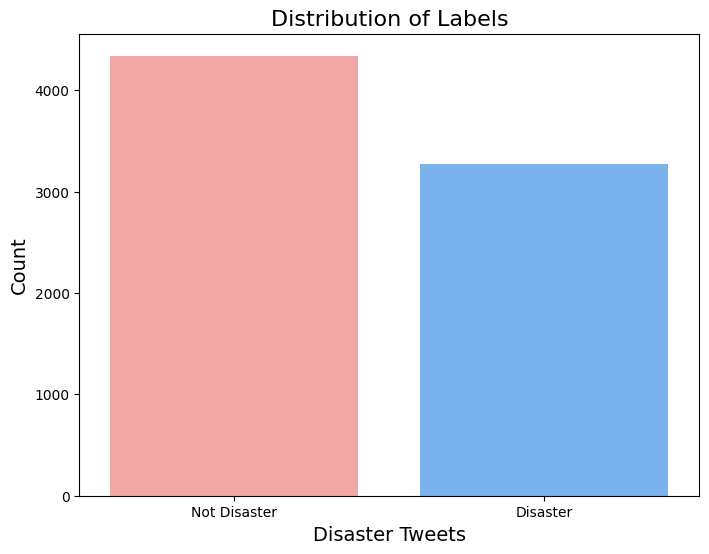

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='label', hue='label', palette=['#FF9999', '#66B2FF'], legend=False)

plt.xticks([0, 1], ['Not Disaster', 'Disaster'])

plt.xlabel('Disaster Tweets', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels', fontsize=16)

plt.show()


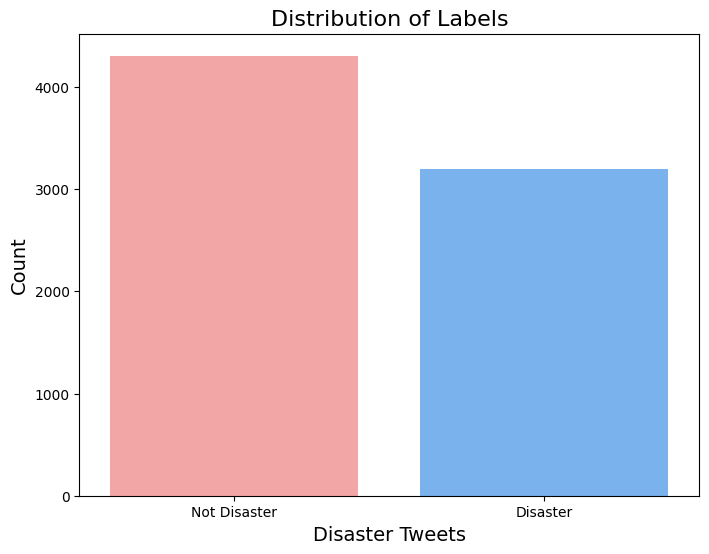

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_processed, x='label', hue='label', palette=['#FF9999', '#66B2FF'], legend=False)

plt.xticks([0, 1], ['Not Disaster', 'Disaster'])

plt.xlabel('Disaster Tweets', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels', fontsize=16)

plt.show()


**Train Test Split**

In [10]:
# Using 10% as testing split.

processed_tweets = df_processed['cleaned_text'].values
processed_labels = df_processed['label'].values

tweet_train, tweet_test, y_train, y_test = train_test_split(processed_tweets, processed_labels, test_size=0.1, random_state=1000)

**Tokenization**

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train)

X_train = tokenizer.texts_to_sequences(tweet_train)
X_test = tokenizer.texts_to_sequences(tweet_test)

vocab_size = len(tokenizer.word_index) + 1

print(tweet_test[2])
print(X_train[2])
print(vocab_size)
maxlen = max(len(seq) for seq in X_train)
maxlen_test = max(len(seq) for seq in X_test)
print(maxlen, maxlen_test)


police man killed ex grandmother after son wasnampt named after him httptcondcyqri omg absolutely crazy
[4069, 1193, 4, 6122, 1117, 1896, 10, 1, 6123, 859, 2, 151, 538, 1118, 27, 6124]
20220
31 27


**Padding**

In [12]:
# Training
print(maxlen)
# maxlen = 128
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# Testing
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

31
[1192   81    3 6119 4066 1535   14 1053 4067 6120 3122  432 2138    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
Shape of training tensor:  (6752, 31)
Shape of testing tensor:  (751, 31)


**Embedding with GloVe Using matrices of 100 dimensions for each word and storing the embedding matrix extracted from GLoVe in a variable called embedding_matrix**

In [13]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix  = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix



In [14]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/CSE427/Project/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

print(embedding_matrix.shape)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size
# covers 62.4% of the vocab size.

(20220, 100)


0.5710187932739862

# Creating Multiple Model

**Model-1 : Shallow RNN Model with an embedding layer, a dense layer with 10 hidden units and a output layer.**

In [15]:
# Dimensions
print(X_train.shape)
print(embedding_matrix.shape)
print(vocab_size)
print(maxlen)

# Model (explicit input = input_shape)
model1 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    GlobalMaxPool1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compilation
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

#Summary
model1.summary()

(6752, 31)
(20220, 100)
20220
31
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 100)           2022000   
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2035057 (7.76 MB)
Trainable params: 2035057 (7.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model-2

In [16]:
# Defined Parameters:
n_lstm = 32
drop_rate = 0.1

# Model
model1 = Sequential([
    Embedding(vocab_size, embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    LSTM(n_lstm, return_sequences=False),
    Dropout(drop_rate),
    Dense(1, activation='sigmoid')
])

#Compilation
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
#Summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 100)           2022000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2039057 (7.78 MB)
Trainable params: 2039057 (7.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model-3

In [17]:
# Defined Parameters:
n_lstm = 32
drop_rate = 0.1

# Model
model2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    Bidirectional(LSTM(n_lstm, return_sequences=False)),
    Dropout(drop_rate),
    Dense(1, activation='sigmoid')
])

# Model Compilation
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy',]) #'Precision', 'Recall'

# Model Summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 100)           2022000   
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2056113 (7.84 MB)
Trainable params: 2056113 (7.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model-4

In [18]:
# Defined Parameters
n_gru = 32
drop_rate = 0.1

# Model
model4 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    GRU(n_gru, return_sequences=False),  # Unidirectional GRU
    Dropout(drop_rate),
    Dense(1, activation='sigmoid')
])

# Model Compilation
model4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Model Summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 100)           2022000   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2034897 (7.76 MB)
Trainable params: 2034897 (7.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model-5

In [19]:
# Defined Parameters
n_gru = 24
drop_rate = 0.1

# Model
model5 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    Bidirectional(GRU(n_gru, return_sequences=False)),  # Bidirectional GRU
    Dropout(drop_rate),
    Dense(1, activation='sigmoid')
])

# Model Compilation
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 31, 100)           2022000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 48)                18144     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 48)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 49        
                                                                 
Total params: 2040193 (7.78 MB)
Trainable params: 2040193 (7.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training, Testing and Visual Representation of output.

**General Code for Plotting.**

In [20]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(train_metrics, test_metrics):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Train')
    rects2 = ax.bar(x + width/2, test_metrics, width, label='Test')

    ax.set_ylabel('Scores')
    ax.set_title('Training vs Testing Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

**Model - 01 RNN (128 Hidden Neurons)**

In [21]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
basic_rnn = model1.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model1.predict(X_train)
y_test_pred_prob = model1.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
190/190 [==============================] - 12s 55ms/step - loss: 0.5160 - accuracy: 0.7492 - val_loss: 0.4924 - val_accuracy: 0.7796
Epoch 2/20
190/190 [==============================] - 10s 51ms/step - loss: 0.3730 - accuracy: 0.8453 - val_loss: 0.4511 - val_accuracy: 0.8018
Epoch 3/20
190/190 [==============================] - 10s 51ms/step - loss: 0.2831 - accuracy: 0.8940 - val_loss: 0.4799 - val_accuracy: 0.7988
Epoch 4/20
190/190 [==============================] - 10s 50ms/step - loss: 0.1797 - accuracy: 0.9375 - val_loss: 0.6127 - val_accuracy: 0.7751
Epoch 5/20
190/190 [==============================] - 10s 51ms/step - loss: 0.0903 - accuracy: 0.9720 - val_loss: 0.7552 - val_accuracy: 0.7648
Training Loss: 0.3035
Training Accuracy: 0.8894
Testing Loss: 0.4240
Testing Accuracy: 0.8123
24/24 [==============================] - 0s 4ms/step

Training Metrics:
Accuracy: 0.8894
Precision: 0.9106
Recall: 0.8220
F1 Score: 0.8641

Testing Metrics:
Accuracy: 0.8123
Precision: 0

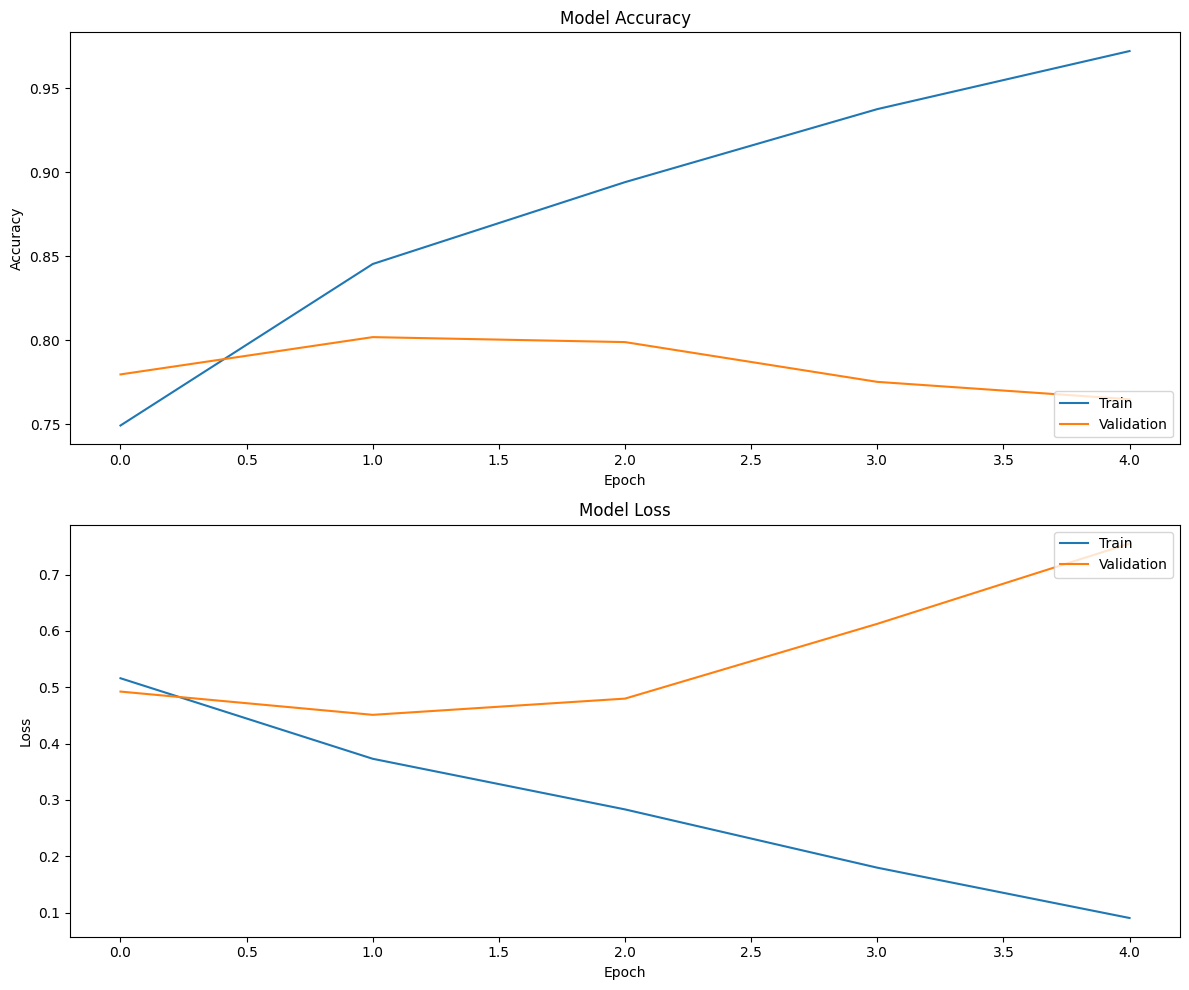

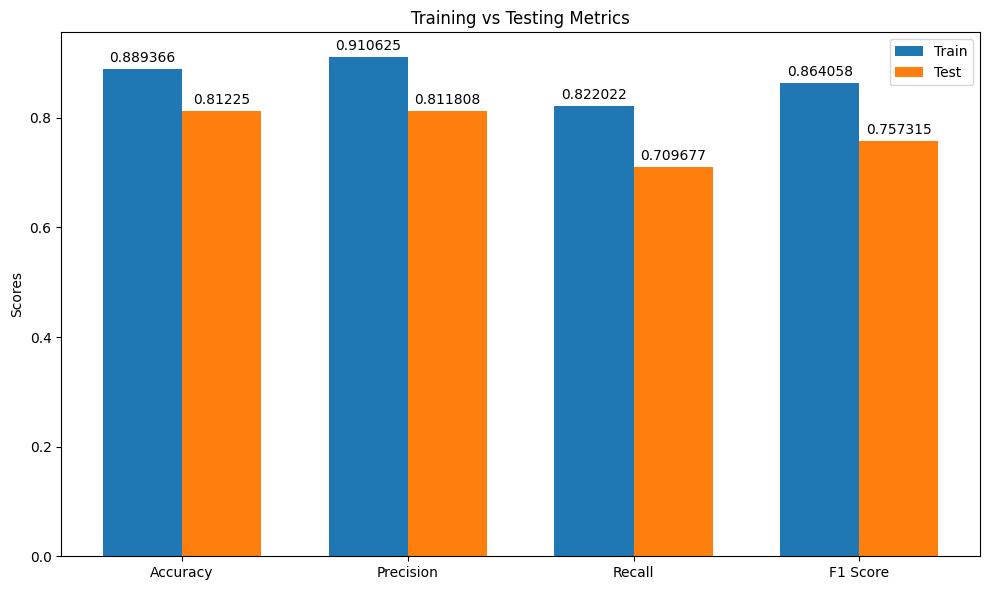

Final Training Loss: 0.3035
Final Testing Loss: 0.4240


In [22]:
# Plot training history
plot_training_history(basic_rnn)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

**Model-02 Uni-LSTM.**

In [23]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
uni_LSTM = model1.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model1.predict(X_train)
y_test_pred_prob = model1.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
190/190 [==============================] - 10s 51ms/step - loss: 0.2782 - accuracy: 0.8945 - val_loss: 0.4825 - val_accuracy: 0.7959
Epoch 2/20
190/190 [==============================] - 10s 51ms/step - loss: 0.1953 - accuracy: 0.9353 - val_loss: 0.5469 - val_accuracy: 0.7885
Epoch 3/20
190/190 [==============================] - 10s 51ms/step - loss: 0.1220 - accuracy: 0.9595 - val_loss: 0.6958 - val_accuracy: 0.7648
Epoch 4/20
190/190 [==============================] - 10s 51ms/step - loss: 0.0780 - accuracy: 0.9766 - val_loss: 0.8009 - val_accuracy: 0.7515
Training Loss: 0.2235
Training Accuracy: 0.9233
Testing Loss: 0.4458
Testing Accuracy: 0.7989
24/24 [==============================] - 0s 4ms/step

Training Metrics:
Accuracy: 0.9233
Precision: 0.9315
Recall: 0.8857
F1 Score: 0.9081

Testing Metrics:
Accuracy: 0.7989
Precision: 0.7870
Recall: 0.7032
F1 Score: 0.7428


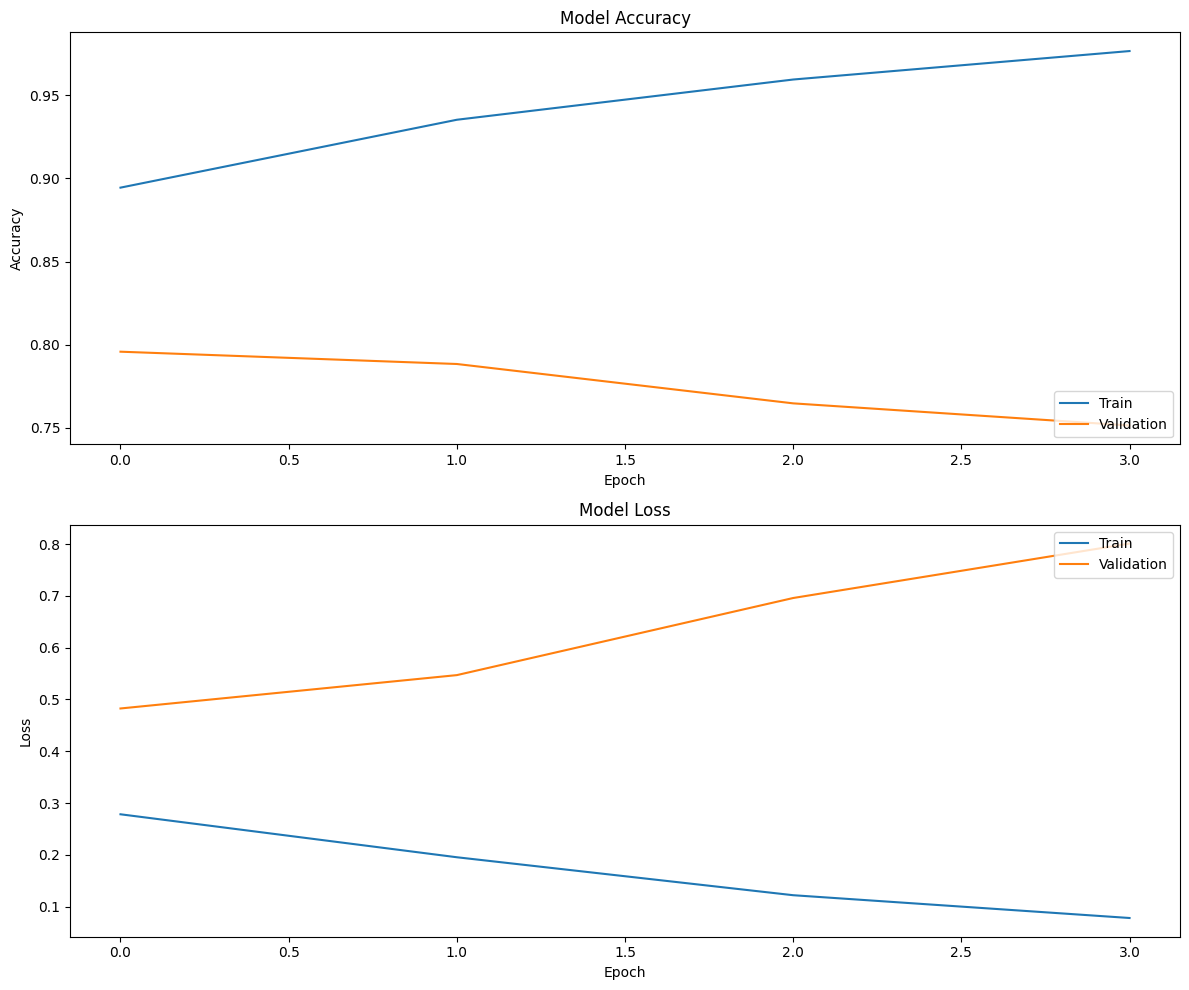

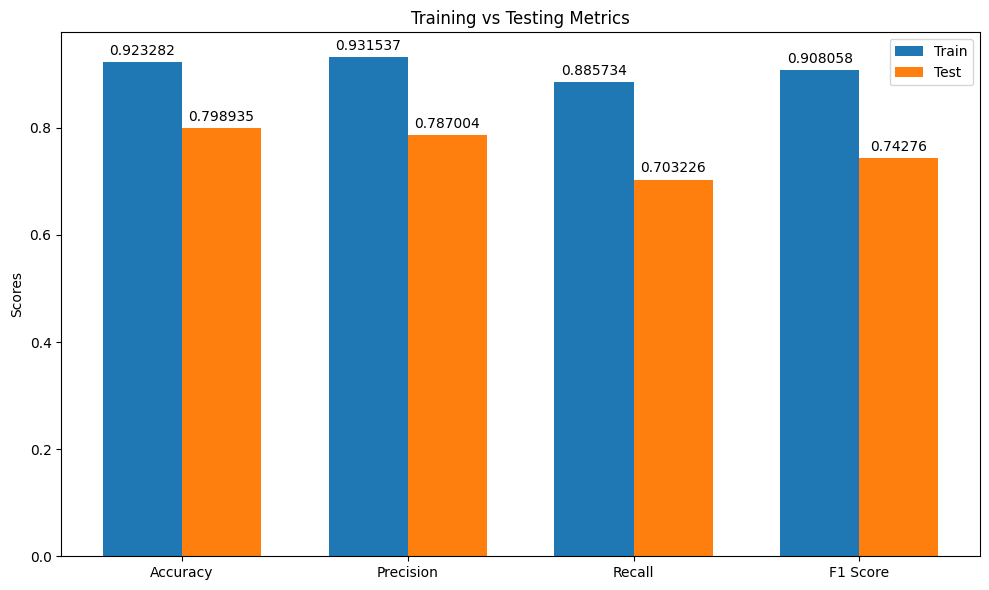

Final Training Loss: 0.2235
Final Testing Loss: 0.4458


In [24]:
# Plot training history
plot_training_history(uni_LSTM)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

**Model-03 Bi-LSTM.**

In [25]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
bi_LSTM = model2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model2.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model2.predict(X_train)
y_test_pred_prob = model2.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
190/190 [==============================] - 16s 68ms/step - loss: 0.4896 - accuracy: 0.7706 - val_loss: 0.4475 - val_accuracy: 0.8033
Epoch 2/20
190/190 [==============================] - 12s 64ms/step - loss: 0.3654 - accuracy: 0.8483 - val_loss: 0.4654 - val_accuracy: 0.8047
Epoch 3/20
190/190 [==============================] - 12s 65ms/step - loss: 0.2769 - accuracy: 0.8884 - val_loss: 0.4728 - val_accuracy: 0.7988
Epoch 4/20
190/190 [==============================] - 12s 66ms/step - loss: 0.1719 - accuracy: 0.9378 - val_loss: 0.5826 - val_accuracy: 0.7870
Training Loss: 0.3793
Training Accuracy: 0.8415
Testing Loss: 0.4261
Testing Accuracy: 0.8162
24/24 [==============================] - 1s 6ms/step

Training Metrics:
Accuracy: 0.8415
Precision: 0.8966
Recall: 0.7116
F1 Score: 0.7934

Testing Metrics:
Accuracy: 0.8162
Precision: 0.8707
Recall: 0.6516
F1 Score: 0.7454


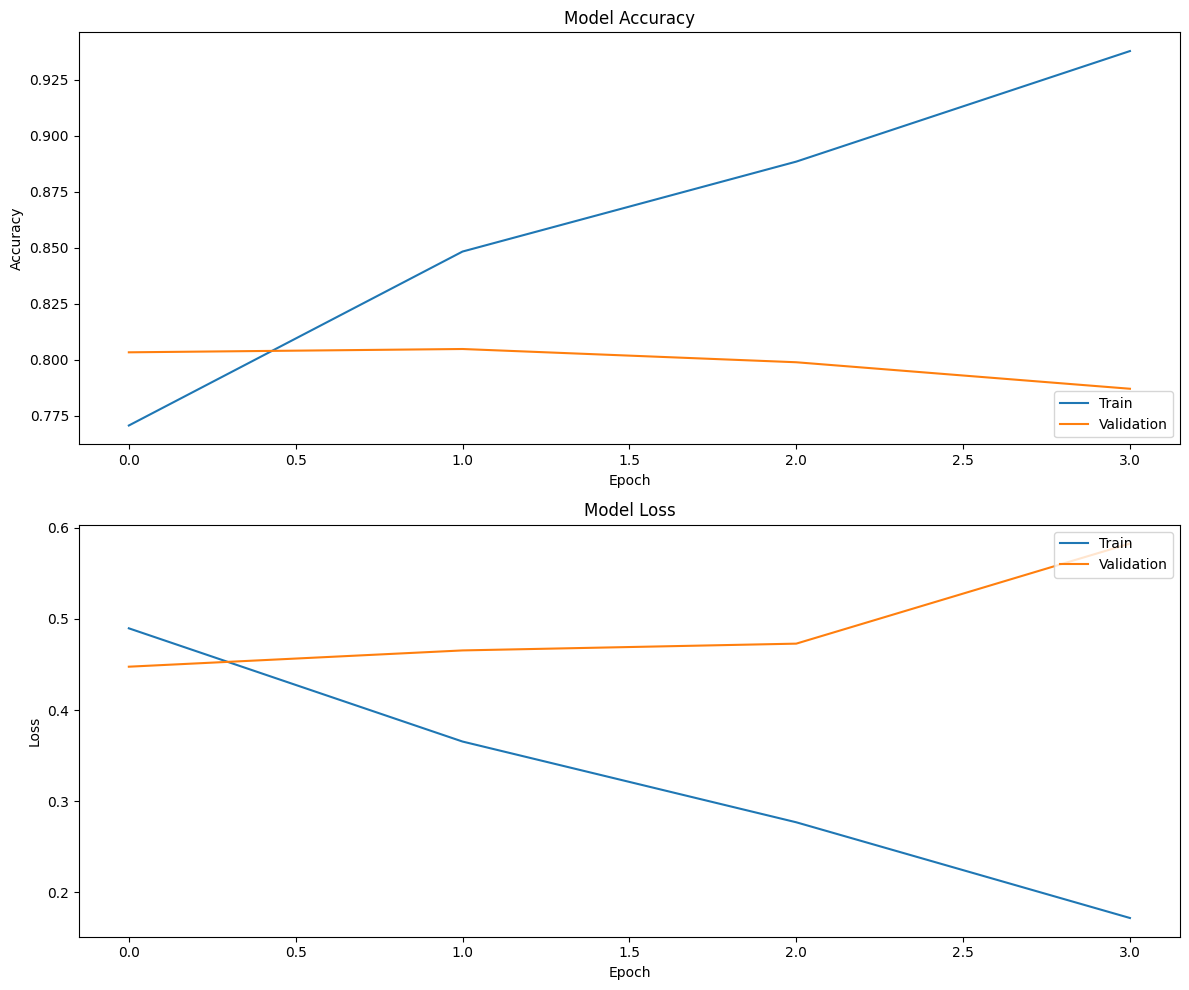

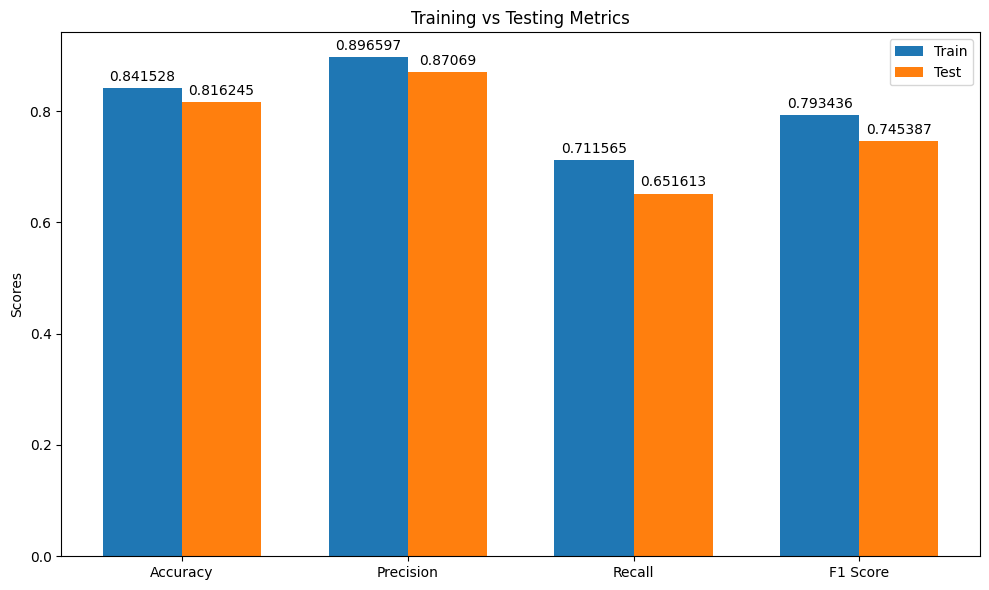

Final Training Loss: 0.3793
Final Testing Loss: 0.4261


In [26]:
# Plot training history
plot_training_history(bi_LSTM)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

**Model-04 Uni-GRU.**

In [27]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
uni_GRU = model4.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model4.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model4.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model4.predict(X_train)
y_test_pred_prob = model4.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
190/190 [==============================] - 12s 55ms/step - loss: 0.6814 - accuracy: 0.5719 - val_loss: 0.6810 - val_accuracy: 0.5592
Epoch 2/20
190/190 [==============================] - 10s 52ms/step - loss: 0.5383 - accuracy: 0.7304 - val_loss: 0.4800 - val_accuracy: 0.8018
Epoch 3/20
190/190 [==============================] - 10s 52ms/step - loss: 0.3397 - accuracy: 0.8678 - val_loss: 0.4627 - val_accuracy: 0.7929
Epoch 4/20
190/190 [==============================] - 10s 52ms/step - loss: 0.2044 - accuracy: 0.9274 - val_loss: 0.5877 - val_accuracy: 0.7766
Epoch 5/20
190/190 [==============================] - 10s 52ms/step - loss: 0.0899 - accuracy: 0.9722 - val_loss: 0.7158 - val_accuracy: 0.7722
Epoch 6/20
190/190 [==============================] - 10s 52ms/step - loss: 0.0576 - accuracy: 0.9822 - val_loss: 0.7817 - val_accuracy: 0.7751
Training Loss: 0.2602
Training Accuracy: 0.9102
Testing Loss: 0.4364
Testing Accuracy: 0.8016
24/24 [==============================] - 0

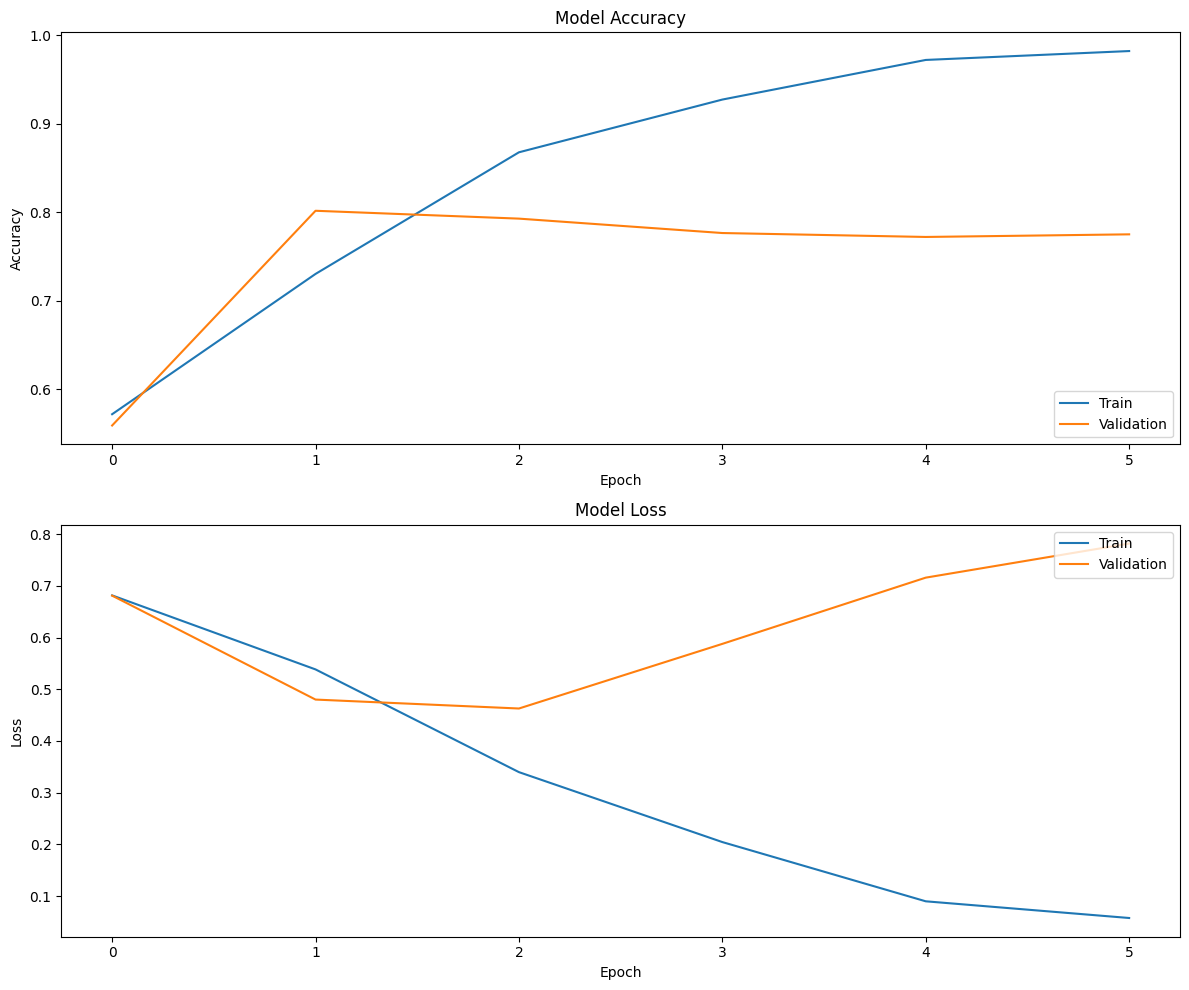

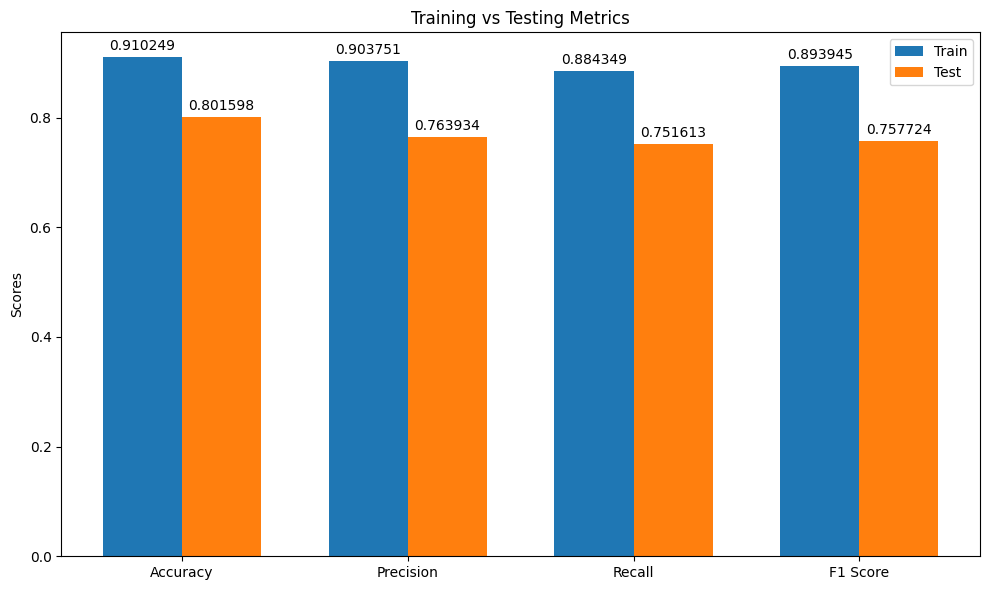

Final Training Loss: 0.2602
Final Testing Loss: 0.4364


In [28]:
# Plot training history
plot_training_history(uni_GRU)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

**Model-05 Bi-GRU.**

In [29]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
bi_GRU = model5.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model5.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model5.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model5.predict(X_train)
y_test_pred_prob = model5.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
190/190 [==============================] - 16s 67ms/step - loss: 0.5303 - accuracy: 0.7442 - val_loss: 0.4604 - val_accuracy: 0.7944
Epoch 2/20
190/190 [==============================] - 12s 63ms/step - loss: 0.3677 - accuracy: 0.8450 - val_loss: 0.4521 - val_accuracy: 0.8047
Epoch 3/20
190/190 [==============================] - 12s 63ms/step - loss: 0.2625 - accuracy: 0.8988 - val_loss: 0.4624 - val_accuracy: 0.8225
Epoch 4/20
190/190 [==============================] - 12s 63ms/step - loss: 0.1448 - accuracy: 0.9506 - val_loss: 0.5414 - val_accuracy: 0.7855
Epoch 5/20
190/190 [==============================] - 12s 63ms/step - loss: 0.0670 - accuracy: 0.9801 - val_loss: 0.6910 - val_accuracy: 0.7855
Training Loss: 0.2944
Training Accuracy: 0.8857
Testing Loss: 0.4126
Testing Accuracy: 0.8216
24/24 [==============================] - 1s 5ms/step

Training Metrics:
Accuracy: 0.8857
Precision: 0.9185
Recall: 0.8040
F1 Score: 0.8575

Testing Metrics:
Accuracy: 0.8216
Precision: 0

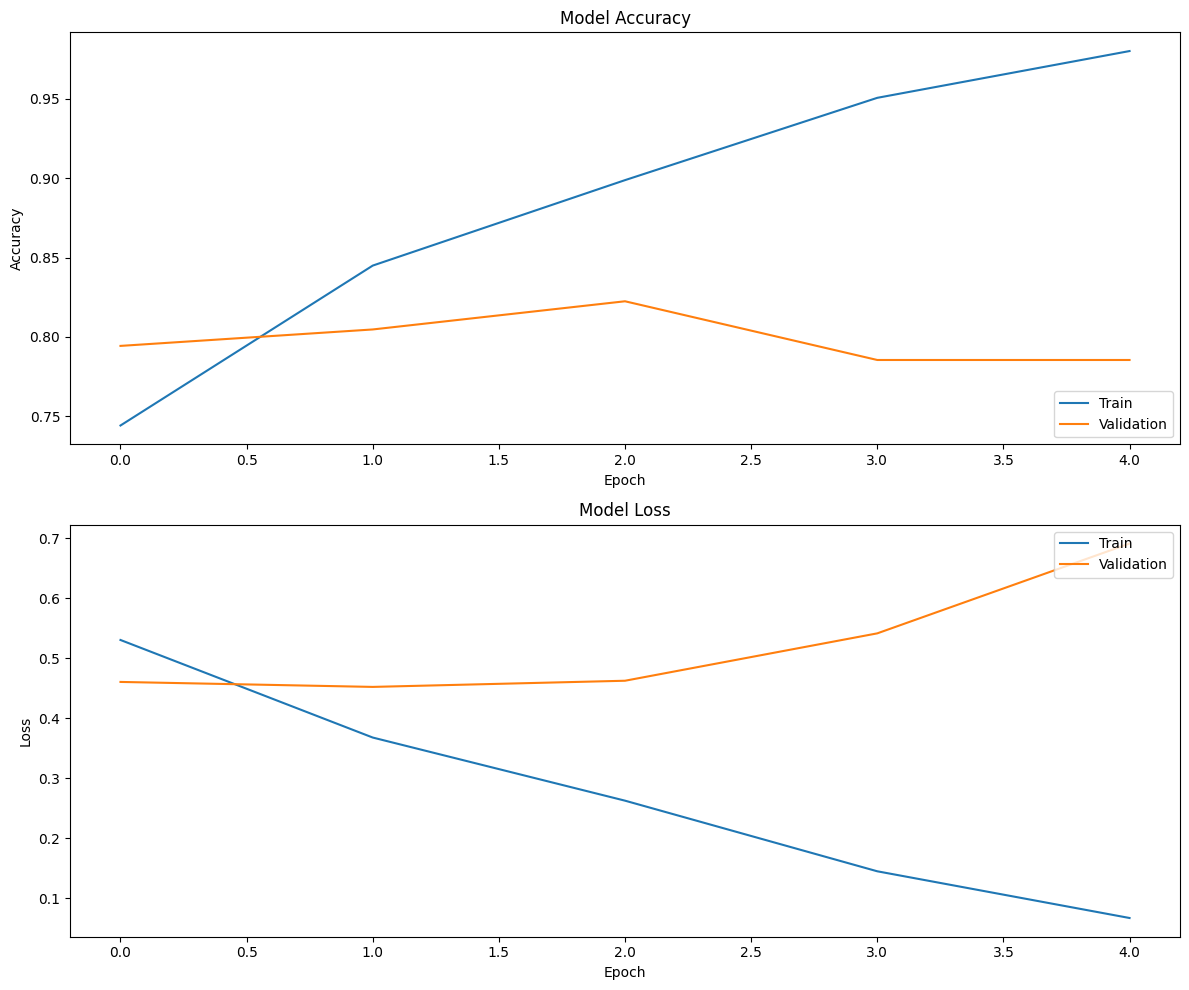

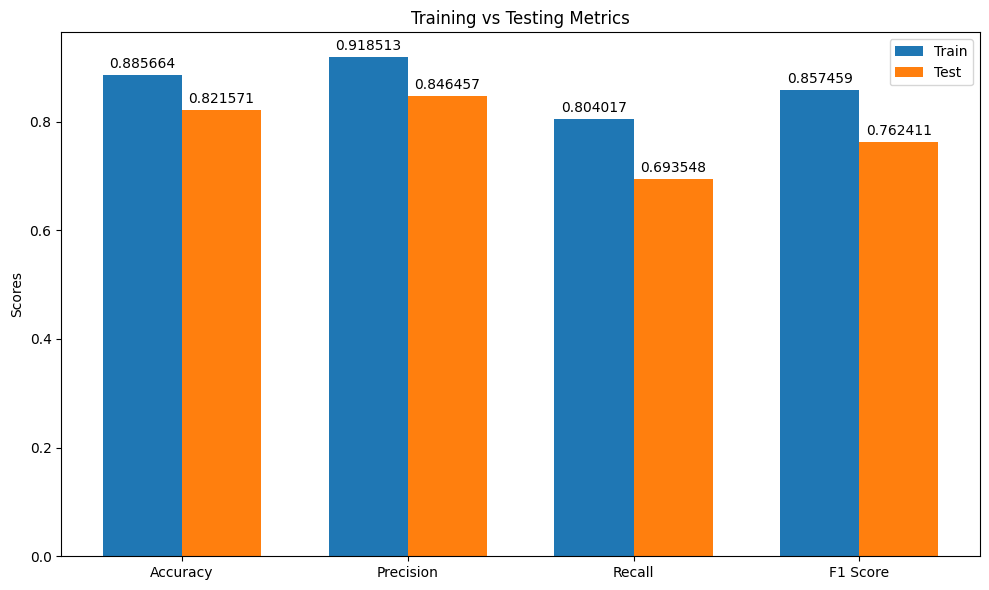

Final Training Loss: 0.2944
Final Testing Loss: 0.4126


In [30]:
# Plot training history
plot_training_history(bi_GRU)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

**Overall Comparaison of differnt model used:**

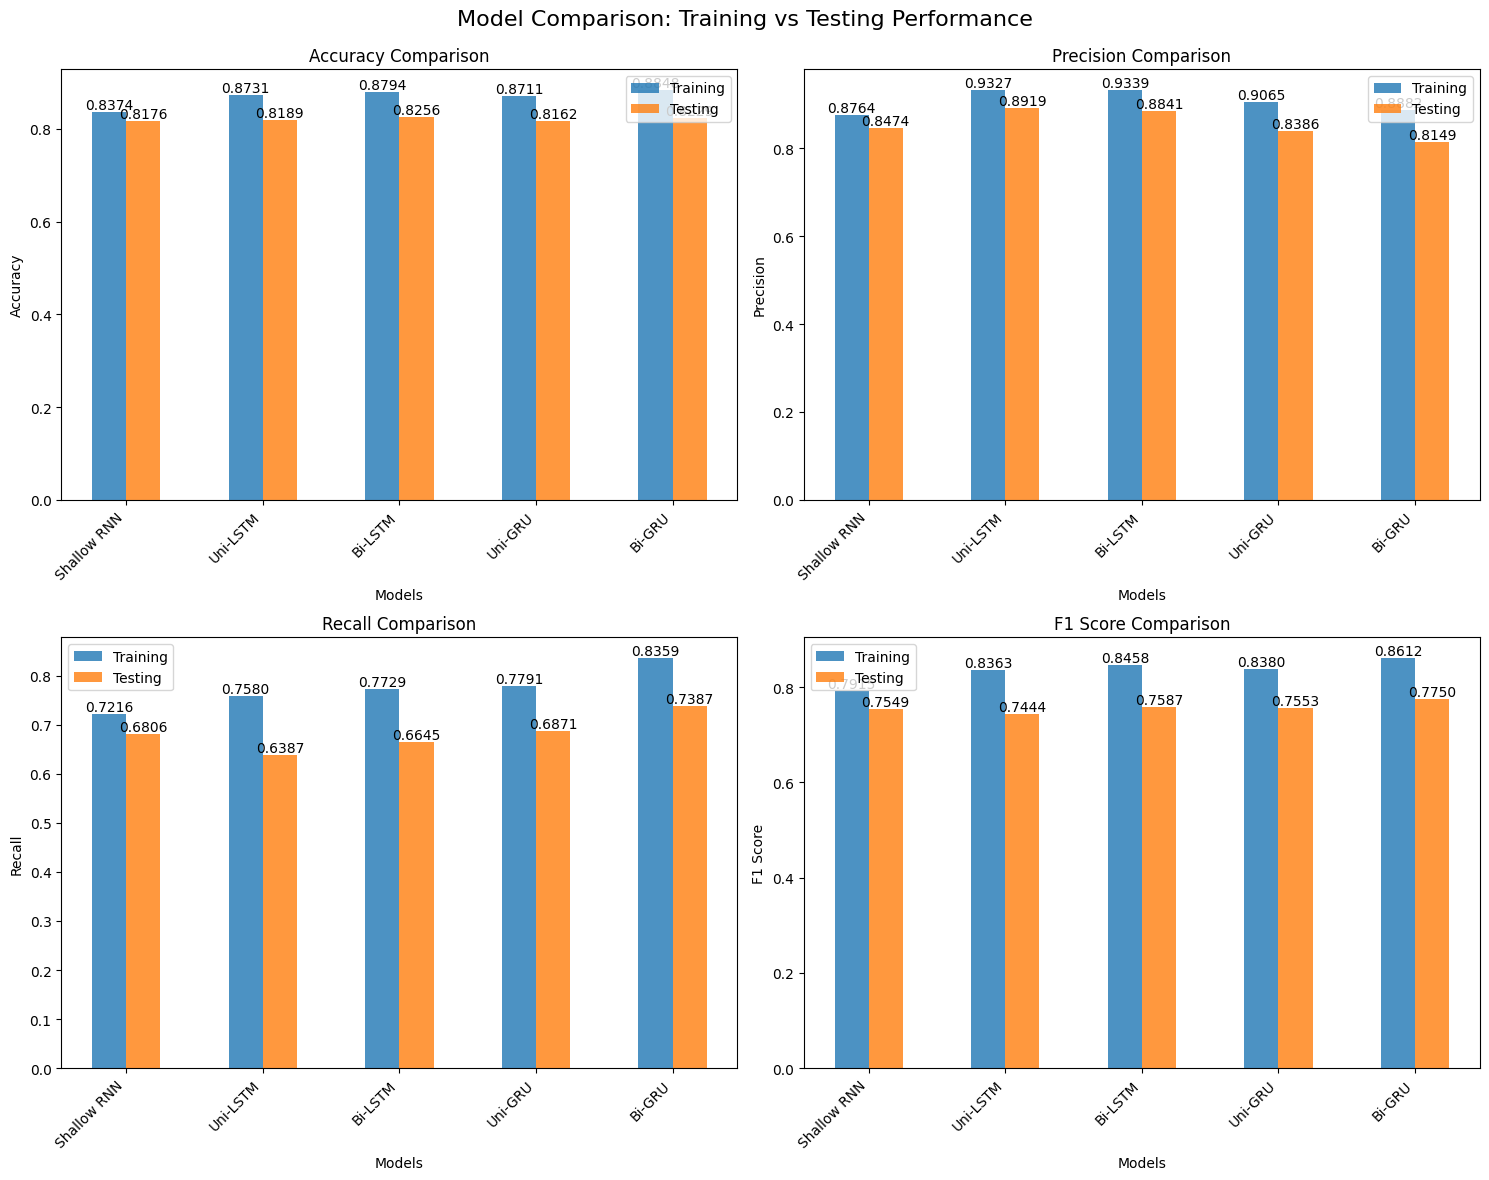

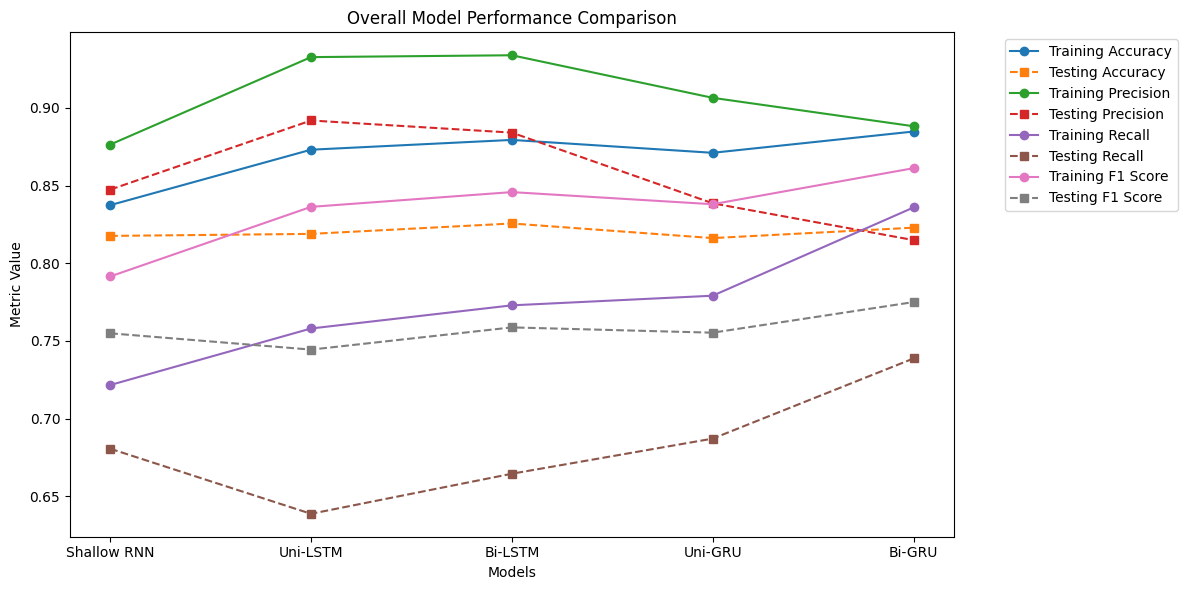

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Shallow RNN', 'Uni-LSTM', 'Bi-LSTM', 'Uni-GRU', 'Bi-GRU']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

training_data = np.array([
    [0.8374, 0.8764, 0.7216, 0.7915],  # Shallow RNN
    [0.8731, 0.9327, 0.7580, 0.8363],  # Uni-LSTM
    [0.8794, 0.9339, 0.7729, 0.8458],  # Bi-LSTM
    [0.8711, 0.9065, 0.7791, 0.8380],  # Uni-GRU
    [0.8848, 0.8882, 0.8359, 0.8612]   # Bi-GRU
])

testing_data = np.array([
    [0.8176, 0.8474, 0.6806, 0.7549],  # Shallow RNN
    [0.8189, 0.8919, 0.6387, 0.7444],  # Uni-LSTM
    [0.8256, 0.8841, 0.6645, 0.7587],  # Bi-LSTM
    [0.8162, 0.8386, 0.6871, 0.7553],  # Uni-GRU
    [0.8229, 0.8149, 0.7387, 0.7750]   # Bi-GRU
])

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Comparison: Training vs Testing Performance', fontsize=16)

bar_width = 0.25
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    ax = axs[i // 2, i % 2]

    ax.bar(index, training_data[:, i], bar_width, label='Training', alpha=0.8)
    ax.bar(index + bar_width, testing_data[:, i], bar_width, label='Testing', alpha=0.8)

    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

    # Add value labels
    for j, v in enumerate(training_data[:, i]):
        ax.text(j, v, f'{v:.4f}', ha='center', va='bottom')
    for j, v in enumerate(testing_data[:, i]):
        ax.text(j + bar_width, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Line plot for overall comparison
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.plot(models, training_data[:, i], marker='o', label=f'Training {metric}')
    plt.plot(models, testing_data[:, i], marker='s', linestyle='--', label=f'Testing {metric}')

plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Overall Model Performance Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [32]:
clear_session()